In [1]:
import json
import requests
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
metadata_api = "https://maayanlab.cloud/sigcom-lincs/metadata-api"
data_api = "https://maayanlab.cloud/sigcom-lincs/data-api/api/v1"

## Example 1: Find drugs that induces the top co-mentioned genes with wound healing from literature
### Step 1: Perform term search on Geneshot API
First we need to find the number of times a gene was co-mentioned with wound healint on literature.

In [3]:
GENESHOT_URL = 'https://maayanlab.cloud/geneshot/api/search'
payload = {"rif": "autorif", "term": "wound healing"}

res = requests.post(GENESHOT_URL, json=payload)
results = res.json()
results

{'PubMedID_count': 187227,
 'gene_count': {'18S_RRNA': [149, 0.007933127462464062],
  'A2M': [71, 0.011997296383913484],
  'ABCG2': [102, 0.00865874363327674],
  'ABHD11-AS1': [4, 0.08163265306122448],
  'AC011558.5': [1, 1.0],
  'AC024560.2': [1, 0.25],
  'AC026904.1': [1, 0.16666666666666666],
  'AC067945.2': [3, 0.6],
  'AC091729.7': [1, 1.0],
  'AC092171.2': [1, 0.5],
  'AC093818.1': [1, 0.5],
  'AC097662.2': [2, 1.0],
  'AC114812.8': [1, 1.0],
  'AC132217.4': [1, 0.3333333333333333],
  'ACAN': [330, 0.03091045335331585],
  'ACE': [264, 0.0031452535264963784],
  'ACP5': [269, 0.03083447959651536],
  'ACTA1': [87, 0.017313432835820895],
  'ACTA2-AS1': [2, 0.09523809523809523],
  'ACTC1': [56, 0.015748031496062992],
  'ACTG1': [182, 0.01545385072599134],
  'ADAM10': [56, 0.01330166270783848],
  'ADAM17': [107, 0.02048631054949263],
  'ADIPOQ': [166, 0.004821656790984083],
  'ADORA2A': [82, 0.0082],
  'ADRB2': [55, 0.006723716381418093],
  'AF001548.6': [1, 1.0],
  'AFP': [85, 0.00235

For this we only get the top 200 genes based on the number of publication co-mentions

In [4]:
top_genes = sorted(list(results['gene_count'].keys()), key=lambda x: results['gene_count'][x][0], reverse=True)[0:200]

### Step 2: Convert the top genes to sigcom-lincs gene UUIDs

In [5]:
payload = {
    "filter": {
        "where": {
            "meta.symbol": {
                "inq": top_genes
            }
        },
        "fields": ["id", "meta.symbol"]
    }
}

res = requests.post(metadata_api + "/entities/find", json=payload)
res.json()

[{'id': 'ede1031e-3603-45e0-a4c1-aef8cafbecdb', 'meta': {'symbol': 'ACAN'}},
 {'id': '25f23ecf-b81f-4db6-b847-37f37126b58f', 'meta': {'symbol': 'ACE'}},
 {'id': '6f7f33fd-fc8c-49eb-8561-9c056ae101bb', 'meta': {'symbol': 'ACP5'}},
 {'id': '3c6f8c5c-d054-4271-aebe-069807e3f44f', 'meta': {'symbol': 'AKT1'}},
 {'id': '26394c7b-03c2-4753-85a7-d929a51974fb', 'meta': {'symbol': 'ALB'}},
 {'id': 'f6f38f73-26d0-47c1-846a-ea4332b572c6', 'meta': {'symbol': 'ANGPT1'}},
 {'id': 'b84ea7f2-f3de-449d-89b1-e7f7f1fb04eb', 'meta': {'symbol': 'ANXA5'}},
 {'id': '58e7a1fd-8c50-456d-bf7c-5010b89583e6', 'meta': {'symbol': 'ARG1'}},
 {'id': '5be0e010-e30c-49bf-a53a-bcdc2f702249', 'meta': {'symbol': 'ATP4A'}},
 {'id': '044307e4-b9e4-4681-9af5-cf741920855f', 'meta': {'symbol': 'BCL2L1'}},
 {'id': '76dc280d-bdca-47f5-888e-9ca2043e285d', 'meta': {'symbol': 'BDNF'}},
 {'id': 'aa478235-9065-4298-aeb0-2e223b800c69', 'meta': {'symbol': 'BGLAP'}},
 {'id': 'deddbe93-fe83-4322-b751-9f437c6bda8e', 'meta': {'symbol': 'BGN

Notice that we are down to 192 genes, this means that 8 genes has no direct match on our database.

In [6]:
entities = [i["id"] for i in res.json()]
len(entities)

192

### Step 3: Get the name of the dataset that we want to use
One way to do this is to perform a full text search on the sigcom lincs datasets.

In [7]:
payload = {
    "filter": {
        "where": {
            "meta": {
                "fullTextSearch": "Chemical Perturbation 2021"
            }
        }
    }
}

res = requests.post(metadata_api + "/libraries/find", json=payload)
res.json()

[{'$validator': '/dcic/signature-commons-schema/v5/core/library.json',
  'id': '54198d6e-fe17-5ef8-91ac-02b425761653',
  'resource': 'f2bace34-022d-4147-9ca4-7b6e450c794d',
  'dataset': 'l1000_cp',
  'dataset_type': 'rank_matrix',
  'meta': {'date': '2021-06-10',
   'icon': './static/images/lincs/CMap.png',
   'size': '35.57 GB',
   'assay': 'L1000 mRNA profiling assay',
   'center': 'LINCS Center for Transcriptomics (Broad Institute)',
   '$validator': 'https://raw.githubusercontent.com/MaayanLab/sigcom-lincs/main/validators/lincs_datasets.json',
   'total_size': 35565630496,
   'url_prefix': 'https://lincs-dcic.s3.amazonaws.com/LINCS-sigs-2021/cd/cp',
   'datalevel_5': {'id': 'L1000_cp',
    'date': '2021-06-10',
    'link': 'https://clue.io/data/CMap2020#LINCS2020',
    'size': '35.57 GB',
    'version': '1',
    'file_url': 'https://lincs-dcic.s3.amazonaws.com/LINCS-sigs-2021/gctx/cd-coefficient/cp_coeff_mat.gctx',
    'filesize': 35565630496,
    'datalevel': 5,
    'description':

We note the dataset

In [8]:
chem_pert_dataset = res.json()[0]
dataset = chem_pert_dataset['dataset']

### Step 4: Perform signature search

In [9]:
payload = {
    "entities": entities, # from step 2
    "database": dataset, # from step 3
    "limit": 100, # Get the top 100 signatures that up- or down-regulate the gene set
}

res = requests.post(data_api + "/enrich/rank", json=payload)
res.json()

{'queryTimeSec': 2.242,
 'up': 343181,
 'down': 374874,
 'results': [{'p-value': 0,
   'p-value-bonferroni': 0,
   'fdr': 0,
   'rank': 0,
   'zscore': 8.579635334694734,
   'type': 'up',
   'uuid': '8ffc6e07-7e2c-56cf-9a12-b732d64215c0',
   'direction': 1},
  {'p-value': 0,
   'p-value-bonferroni': 0,
   'fdr': 0,
   'rank': 1,
   'zscore': 8.530019246492552,
   'type': 'up',
   'uuid': '25cd5388-3ef5-55dd-8f2a-bb2d1f6f4837',
   'direction': 1},
  {'p-value': 0,
   'p-value-bonferroni': 0,
   'fdr': 0,
   'rank': 2,
   'zscore': 8.330863745135627,
   'type': 'up',
   'uuid': '2ca8b374-a825-5ee3-9411-7d8d73a8e3a8',
   'direction': 1},
  {'p-value': 2.220446049250313e-16,
   'p-value-bonferroni': 1.5944023878944336e-10,
   'fdr': 1.993002984868042e-11,
   'rank': 3,
   'zscore': 8.178455018311109,
   'type': 'up',
   'uuid': '4c42a5a3-c6f8-56bf-b2fb-46e8c3cc48ba',
   'direction': 1},
  {'p-value': 2.220446049250313e-16,
   'p-value-bonferroni': 1.5944023878944336e-10,
   'fdr': 1.993002

The results field returns the top signatures that up- or down-regulate our wound healing gene set. It provides (1) the scores, (2) the ranking of that signature, (3) the type of the signature (up or down), and (4) the UUID of the signatures. At the moment, this still don't make sense since we don't know the metadata of the signatures. Hence, we need to resolve the signature metadata.

### Step 5: Resolve the metadata
Since we only want to search for drugs that induces (or up-regulate) this gene set, we only focus on the those whose `type == 'up'`

In [10]:
signatures = [i for i in res.json()["results"] if i["type"] == "up"]
len(signatures)

100

In [11]:
payload = {
    "filter": {
        "where": {
            "id": {
                "inq": [i["uuid"] for i in signatures]
            }
        }
    }
}
res = requests.post(metadata_api + "/signatures/find", json=payload)
res.json()

[{'$validator': '/dcic/signature-commons-schema/v5/core/signature.json',
  'id': '00fddb79-b5cc-59dd-9af3-b85567f936d8',
  'library': '54198d6e-fe17-5ef8-91ac-02b425761653',
  'meta': {'md5': 'afc7a51dd1df7ae8a9de59796752912b',
   'sha256': 'c772b5199bf2f3333a9e48cb9c8bd45a0f8217b96e9b814bc21b46b7fb0b515b',
   'tissue': 'epithelium',
   'anatomy': 'UBERON:0000483',
   'cmap_id': 'ASG003_XC.P033_24H:D10',
   'version': 1,
   'filename': 'L1000_LINCS_DCIC_ASG003_XC.P033_24H_D10_digoxin_10uM.tsv',
   'local_id': 'ASG003_XC.P033_24H_D10_digoxin_10uM',
   'cell_line': 'XC.P033',
   'pert_dose': '10 uM',
   'pert_name': 'digoxin',
   'pert_time': '24 h',
   'pert_type': 'Chemical',
   '$validator': 'https://raw.githubusercontent.com/MaayanLab/sigcom-lincs/main/validators/l1000_signatures.json',
   'data_level': 5,
   'pubchem_id': 2724385,
   'creation_time': '2021-05-07',
   'persistent_id': 'https://lincs-dcic.s3.amazonaws.com/LINCS-sigs-2021/cd/cp/L1000_LINCS_DCIC_ASG003_XC.P033_24H_D10_d

Now we can add the metadata to the respective signatures

In [12]:
sig_meta = {i["id"]: i for i in res.json()}
resolved = []
for i in signatures:
    sig_id = i["uuid"]
    r = {
        "local_id": sig_meta[sig_id]["meta"].get("local_id"),
        "pert_name": sig_meta[sig_id]["meta"].get("pert_name"),
        "pert_dose": sig_meta[sig_id]["meta"].get("pert_dose"),
        "pert_time": sig_meta[sig_id]["meta"].get("pert_time"),
        "cell_line": sig_meta[sig_id]["meta"].get("cell_line"),
        "tissue": sig_meta[sig_id]["meta"].get("tissue"),
        "zscore": i["zscore"],
        "p-value": i["p-value"],
        "rank": i["rank"],
        "type": i["type"],
    }
    resolved.append(r)
resolved

[{'local_id': 'AICHI001_THP1_4H_C03_tozasertib_0.66uM',
  'pert_name': 'tozasertib',
  'pert_dose': '0.66 uM',
  'pert_time': '4 h',
  'cell_line': 'THP1',
  'tissue': 'blood',
  'zscore': 8.579635334694734,
  'p-value': 0,
  'rank': 0,
  'type': 'up'},
 {'local_id': 'AML001_HL60_6H_K08_BRD-K68552125_3.33uM',
  'pert_name': 'BRD-K68552125',
  'pert_dose': '3.33 uM',
  'pert_time': '6 h',
  'cell_line': 'HL60',
  'tissue': 'blood',
  'zscore': 8.530019246492552,
  'p-value': 0,
  'rank': 1,
  'type': 'up'},
 {'local_id': 'PAC069_U2OS_6H_L22_BRD-K06765193_20uM',
  'pert_name': 'BRD-K06765193',
  'pert_dose': '20 uM',
  'pert_time': '6 h',
  'cell_line': 'U2OS',
  'tissue': 'bone tissue',
  'zscore': 8.330863745135627,
  'p-value': 0,
  'rank': 2,
  'type': 'up'},
 {'local_id': 'ASG003_XC.P910_24H_L04_entinostat_10uM',
  'pert_name': 'entinostat',
  'pert_dose': '10 uM',
  'pert_time': '24 h',
  'cell_line': 'XC.P910',
  'tissue': 'epithelium',
  'zscore': 8.178455018311109,
  'p-value': 

In [13]:
df = pd.DataFrame(resolved).set_index("local_id").sort_values("zscore", ascending=False)
df.head(10)

,pert_name,pert_dose,pert_time,cell_line,tissue,zscore,p-value,rank,type
local_id,,,,,,,,,
AICHI001_THP1_4H_C03_tozasertib_0.66uM,tozasertib,0.66 uM,4 h,THP1,blood,8.579635,0.000000e+00,0,up
AML001_HL60_6H_K08_BRD-K68552125_3.33uM,BRD-K68552125,3.33 uM,6 h,HL60,blood,8.530019,0.000000e+00,1,up
PAC069_U2OS_6H_L22_BRD-K06765193_20uM,BRD-K06765193,20 uM,6 h,U2OS,bone tissue,8.330864,0.000000e+00,2,up
ASG003_XC.P910_24H_L04_entinostat_10uM,entinostat,10 uM,24 h,XC.P910,epithelium,8.178455,2.220446e-16,3,up
REP.A011_A375_24H_C13_ciprofloxacin_10uM,ciprofloxacin,10 uM,24 h,A375,skin of body,8.173910,2.220446e-16,4,up
CVD001_PHH_6H_C10_BRD-K74305673_10uM,BRD-K74305673,10 uM,6 h,PHH,liver,8.094973,6.661338e-16,5,up
PAC001_U2OS_6H_D17_bufalin_10uM,bufalin,10 uM,6 h,U2OS,bone tissue,8.079118,6.661338e-16,6,up
PAC001_U2OS_6H_I12_BRD-K68552125_8uM,BRD-K68552125,8 uM,6 h,U2OS,bone tissue,7.857511,3.996803e-15,7,up
HOG001_A549_6H_B14_ingenol_10uM,ingenol,10 uM,6 h,A549,lung,7.848023,4.218847e-15,8,up


The fourth drug, entinostat (epithelium tissue) is a known histone deacetylase inhibitor

![entinostat](./entinostat.png)

And while there is sparse literature directly linking entinostat to wound healing, a study about another HDAC inhibitor shows its role on the improvement of wound healing.
![HDAC](./HDAC.png)

### Step 6: Benchmark how well entinostat up-regulate our input gene set
#### Step 6.1 Fetch all entinostat signatures

In [14]:
libid = chem_pert_dataset["id"]
payload = {
    "filter": {
        "where": {
            "meta.pert_name": "entinostat",
            "library": libid
        }
    }
}

res = requests.post(metadata_api + "/signatures/find", json=payload)
entinostat_signatures = res.json()
len(entinostat_signatures)

988

#### Step 6.2 Perform signature search on the celastrol signatures

In [15]:
payload = {
    "entities": entities, # from step 2
    "database": dataset, # from step 3
    "signatures": [i["id"] for i in entinostat_signatures]
}

res = requests.post(data_api + "/enrich/rank", json=payload)
results = res.json()

#### Step 6.3 Generate a ROC curve
We create a ROC curve via a random walk, i.e. given all the ranked signatures that up-regulates our input gene set, we go up the y-axis if the signature's perturbagen is entinostat and right the x-axis if not.

In [16]:
def get_coordinates(result):
    resultInput = result["results"]
    resultInput = sorted(resultInput, key=lambda d: d['rank'])
    maxRank = result["maxRank"]
    up_count = result["up"]
    up_drug_signatures = np.array([0]*(up_count+1))
    up_non_drug_signatures = np.array([0]*(up_count+1))
    
    index = 0
    for i in range(maxRank):
        r = {"type": "-", "rank":-1}
        if index < len(resultInput):
            r = resultInput[index]
        rank = r['rank']
        result_type = r["type"]
        up_index = i+1
        if rank == i:
            index += 1
            if (result_type == "up"):
                up_drug_signatures[up_index] = 1
        else:
            if up_index < len(up_non_drug_signatures):
                up_non_drug_signatures[up_index] = 1
    up_x = np.cumsum(up_non_drug_signatures)
    up_x = up_x/np.max(up_x)
    up_y = np.cumsum(up_drug_signatures)
    up_y = up_y/np.max(up_y)
    
    return up_x, up_y


In [17]:
up_x, up_y = get_coordinates(results)

In [18]:
up_auc = np.trapz(x=up_x, y=up_y)

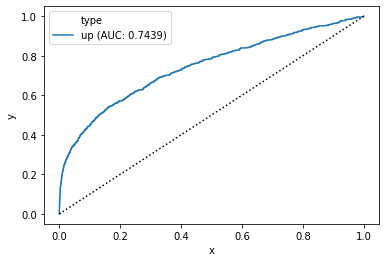

In [19]:
data = {
    "x": up_x,
    "y": up_y,
    "type": ["up (AUC: %.4f)"%up_auc] * len(up_x)
}
df = pd.DataFrame(data)
g = sns.lineplot(data=df, x="x", y="y", hue="type")
lims = [0, 1]
g.plot(lims, lims, 'k:')

## Example 2: Find drugs that mimics the co-expressed genes of KL
For this one, instead of performing signature search on a single gene set, we do it on the top 100 genes that are positively and negatively correlated with KL
### Step 1: Get the co-expressed genes from ARCHS4

In [20]:
api_url = "https://maayanlab.cloud/matrixapi"
payload = {
    "count": 101,
    "id": "KL"
}
res = requests.post(api_url + "/coltop", json=payload)
coltop = res.json()
coltop

{'index': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100],
 'column': 'KL',
 'rowids': ['KL',
  'PLVAP',
  'LYVE1',
  'C1QA',
  'CD93',
  'MRC1',
  'GIMAP8',
  'TMEM176B',
  'VSIG4',
  'C1QB',
  'C1QC',
  'F13A1',
  'GIMAP6',
  'TMEM176A',
  'GGTA1P',
  'FGL2',
  'FHL5',
  'FOLR2',
  'MS4A4A',
  'RAMP3',
  'TNFSF10',
  'MPEG1',
  'VWF',
  'GIMAP4',
  'GPR34',
  'CMKLR1',
  'PECAM1',
  'CSF1R',
  'GJA4',
  'GIMAP5',
  'SELP',
  'RNASE1',
  'CD163',


In [21]:
payload = {
    "count": 100,
    "id": "KL"
}
res = requests.post(api_url + "/colbottom", json=payload)
colbottom = res.json()
colbottom

{'index': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99],
 'column': 'KL',
 'rowids': ['GINS4',
  'UBE2S',
  'SPC24',
  'CDT1',
  'PRR11',
  'RNASEH2A',
  'TONSL',
  'KIF18B',
  'TCOF1',
  'DTYMK',
  'UHRF1',
  'EXOSC2',
  'SKA1',
  'CHAF1B',
  'TROAP',
  'YARS',
  'GINS2',
  'KIAA0101',
  'CDCA3',
  'FOXM1',
  'CDCA4',
  'SGO1',
  'BIRC5',
  'CCNF',
  'AUNIP',
  'PLK1',
  'GINS1',
  'RANBP1',
  'MCM10',
  'EME1',
  'FANCI',
  'PIF1',
  'PTTG1',
  'CENPO

In [22]:
up_genes = coltop["rowids"][1:]
down_genes = colbottom["rowids"]

### Step 2: Convert the genes to UUIDs

In [23]:
payload = {
    "filter": {
        "where": {
            "meta.symbol": {
                "inq": up_genes
            }
        },
        "fields": ["id", "meta.symbol"]
    }
}

res = requests.post(metadata_api + "/entities/find", json=payload)
up_entities = [i["id"] for i in res.json()]

In [24]:
payload = {
    "filter": {
        "where": {
            "meta.symbol": {
                "inq": down_genes
            }
        },
        "fields": ["id", "meta.symbol"]
    }
}

res = requests.post(metadata_api + "/entities/find", json=payload)
mapper = {}
for i in res.json():
    if i["meta"]["symbol"] not in mapper:
        mapper[i["meta"]["symbol"]] = i["id"]
down_entities = list(mapper.values())
len(down_entities)

99

### Step 3: Perform signature search
We already know the dataset previously

In [25]:
payload = {
    "up_entities": up_entities, # from step 2,
    "down_entities": down_entities, # from step 2
    "database": dataset,
    "limit": 100, # Get the top 100 signatures that up- or down-regulate the gene set
}

res = requests.post(data_api + "/enrich/ranktwosided", json=payload)
res.json()

{'queryTimeSec': 6.628,
 'reversers': 382154,
 'results': [{'direction-up': 1,
   'fdr-down': 3.7e-322,
   'logp-avg': 744.4400719213812,
   'logp-fisher': 744.4400719213812,
   'p-up': 0,
   'type': 'mimickers',
   'uuid': '71739ce3-1878-5761-952d-485468f86244',
   'z-down': 12.41084224715591,
   'fdr-up': 5.5e-322,
   'z-sum': 23.389090438120164,
   'z-up': 10.978248190964255,
   'p-down': 0,
   'p-down-bonferroni': 3.547663e-318,
   'rank': 0,
   'p-up-bonferroni': 3.547663e-318,
   'direction-down': -1},
  {'direction-up': 1,
   'fdr-down': 3.7e-322,
   'logp-avg': 744.4400719213812,
   'logp-fisher': 744.4400719213812,
   'p-up': 0,
   'type': 'mimickers',
   'uuid': '8263b943-b26b-5c9f-918d-cb8885219808',
   'z-down': 12.235079137260536,
   'fdr-up': 5.5e-322,
   'z-sum': 21.94442325629374,
   'z-up': 9.709344119033204,
   'p-down': 0,
   'p-down-bonferroni': 3.547663e-318,
   'rank': 1,
   'p-up-bonferroni': 3.547663e-318,
   'direction-down': -1},
  {'direction-up': 1,
   'fdr-

### Step 4: Resolve metadata of the signatures
This time we only want the mimickers

In [26]:
signatures = [i for i in res.json()["results"] if i["type"] == "mimickers"]
len(signatures)

100

In [27]:
payload = {
    "filter": {
        "where": {
            "id": {
                "inq": [i["uuid"] for i in signatures]
            }
        }
    }
}
res = requests.post(metadata_api + "/signatures/find", json=payload)
res.json()

[{'$validator': '/dcic/signature-commons-schema/v5/core/signature.json',
  'id': '0023a5e8-0e6a-5542-bdef-d0128d358c6b',
  'library': '54198d6e-fe17-5ef8-91ac-02b425761653',
  'meta': {'md5': '54398e6c870d6a975591f63139ecf919',
   'doid': 'DOID:1240',
   'sha256': '7af4f64d3f0d2d6aec3fc5fb15fff5615121d8cee4f8c0bdfcf0d2f98155b86d',
   'tissue': 'blood',
   'anatomy': 'UBERON:0000178',
   'cmap_id': 'LJP008_THP1_24H:O05',
   'disease': 'leukemia',
   'version': 1,
   'filename': 'L1000_LINCS_DCIC_LJP008_THP1_24H_O05_PD-0325901_0.12uM.tsv',
   'local_id': 'LJP008_THP1_24H_O05_PD-0325901_0.12uM',
   'cell_line': 'THP1',
   'pert_dose': '0.12 uM',
   'pert_name': 'PD-0325901',
   'pert_time': '24 h',
   'pert_type': 'Chemical',
   '$validator': 'https://raw.githubusercontent.com/MaayanLab/sigcom-lincs/main/validators/l1000_signatures.json',
   'data_level': 5,
   'pubchem_id': 9826528,
   'creation_time': '2021-05-18',
   'persistent_id': 'https://lincs-dcic.s3.amazonaws.com/LINCS-sigs-2021

In [28]:
sig_meta = {i["id"]: i for i in res.json()}
resolved = []
for i in signatures:
    sig_id = i["uuid"]
    r = {
        "local_id": sig_meta[sig_id]["meta"].get("local_id"),
        "pert_name": sig_meta[sig_id]["meta"].get("pert_name"),
        "pert_dose": sig_meta[sig_id]["meta"].get("pert_dose"),
        "pert_time": sig_meta[sig_id]["meta"].get("pert_time"),
        "cell_line": sig_meta[sig_id]["meta"].get("cell_line"),
        "tissue": sig_meta[sig_id]["meta"].get("tissue"),
        "z-sum": i["z-sum"],
        "rank": i["rank"],
        "type": i["type"],
    }
    resolved.append(r)
resolved

[{'local_id': 'REP.B012_HUVEC.A_24H_O21_cobimetinib_0.25uM',
  'pert_name': 'cobimetinib',
  'pert_dose': '0.25 uM',
  'pert_time': '24 h',
  'cell_line': 'HUVEC',
  'tissue': 'umbilical cord',
  'z-sum': 23.389090438120164,
  'rank': 0,
  'type': 'mimickers'},
 {'local_id': 'MUC.CP002_NKDBA_24H_K03_SA-247582_10uM',
  'pert_name': 'SA-247582',
  'pert_dose': '10 uM',
  'pert_time': '24 h',
  'cell_line': 'NKDBA',
  'tissue': 'kidney',
  'z-sum': 21.94442325629374,
  'rank': 1,
  'type': 'mimickers'},
 {'local_id': 'AICHI002_OCILY19_24H_L02_BRD-K08177763_2.5uM',
  'pert_name': 'BRD-K08177763',
  'pert_dose': '2.5 uM',
  'pert_time': '24 h',
  'cell_line': 'OCILY19',
  'tissue': 'lymphoid system',
  'z-sum': 21.89043809834996,
  'rank': 2,
  'type': 'mimickers'},
 {'local_id': 'LJP008_THP1_24H_O02_PD-0325901_3.33uM',
  'pert_name': 'PD-0325901',
  'pert_dose': '3.33 uM',
  'pert_time': '24 h',
  'cell_line': 'THP1',
  'tissue': 'blood',
  'z-sum': 21.487260085821603,
  'rank': 3,
  'type

In [29]:
df = pd.DataFrame(resolved).set_index("local_id").sort_values("z-sum", ascending=False)
df.head(10)

,pert_name,pert_dose,pert_time,cell_line,tissue,z-sum,rank,type
local_id,,,,,,,,
REP.B012_HUVEC.A_24H_O21_cobimetinib_0.25uM,cobimetinib,0.25 uM,24 h,HUVEC,umbilical cord,23.389090,0,mimickers
MUC.CP002_NKDBA_24H_K03_SA-247582_10uM,SA-247582,10 uM,24 h,NKDBA,kidney,21.944423,1,mimickers
AICHI002_OCILY19_24H_L02_BRD-K08177763_2.5uM,BRD-K08177763,2.5 uM,24 h,OCILY19,lymphoid system,21.890438,2,mimickers
LJP008_THP1_24H_O02_PD-0325901_3.33uM,PD-0325901,3.33 uM,24 h,THP1,blood,21.487260,3,mimickers
PBIOA022_HT29_24H_E19_BMS-754807_10uM,BMS-754807,10 uM,24 h,HT29,intestine,21.284384,4,mimickers
AICHI002_OCILY3_24H_E14_BRD-K30520487_2.5uM,BRD-K30520487,2.5 uM,24 h,OCILY3,lymphoid system,21.234039,5,mimickers
PBIOA021_MCF7_24H_N02_BMS-536924_4uM,BMS-536924,4 uM,24 h,MCF7,breast,20.983057,6,mimickers
LJP008_THP1_24H_O05_PD-0325901_0.12uM,PD-0325901,0.12 uM,24 h,THP1,blood,20.818585,7,mimickers
PBIOA022_HCC515_24H_E20_BMS-754807_3.33uM,BMS-754807,3.33 uM,24 h,HCC515,lung,20.712093,8,mimickers


### Step 5: Benchmark cobimetinib signatures
#### Step 5.1: Fetch all cobimetinib signature

In [30]:
libid = chem_pert_dataset["id"]
payload = {
    "filter": {
        "where": {
            "meta.pert_name": "cobimetinib",
            "library": libid
        }
    }
}

res = requests.post(metadata_api + "/signatures/find", json=payload)
cobimetinib_signatures = res.json()
len(cobimetinib_signatures)

278

#### Step 5.2 Perform Signature Search

In [31]:
payload = {
    "up_entities": up_entities, # from step 2,
    "down_entities": down_entities, # from step 2
    "database": dataset, # from step 3
    "signatures": [i["id"] for i in cobimetinib_signatures]
}

res = requests.post(data_api + "/enrich/ranktwosided", json=payload)
results = res.json()

#### Step 5.3: Generate ROC Curve

In [32]:
def get_coordinates(result):
    resultInput = result["results"]
    resultInput = sorted(resultInput, key=lambda d: d['rank'])
    maxRank = result["maxRank"]
    mimickers_count = result["mimickers"]
    mimickers_drug_signatures = np.array([0]*(mimickers_count+1))
    mimickers_non_drug_signatures = np.array([0]*(mimickers_count+1))
    
    index = 0
    for i in range(maxRank):
        r = {"type": "-", "rank":-1}
        if index < len(resultInput):
            r = resultInput[index]
        rank = r['rank']
        result_type = r["type"]
        mimickers_index = i+1
        if rank == i:
            index += 1
            if (result_type == "mimickers"):
                mimickers_drug_signatures[mimickers_index] = 1
        else:
            if mimickers_index < len(mimickers_non_drug_signatures):
                mimickers_non_drug_signatures[mimickers_index] = 1
    mimickers_x = np.cumsum(mimickers_non_drug_signatures)
    mimickers_x = mimickers_x/np.max(mimickers_x)
    mimickers_y = np.cumsum(mimickers_drug_signatures)
    mimickers_y = mimickers_y/np.max(mimickers_y)
    
    return mimickers_x, mimickers_y


In [33]:
mimickers_x, mimickers_y = get_coordinates(results)

In [34]:
mimickers_auc = np.trapz(x=mimickers_x, y=mimickers_y)

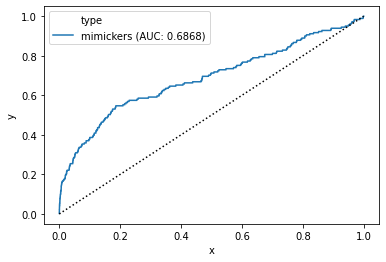

In [35]:
data = {
    "x": mimickers_x,
    "y": mimickers_y,
    "type": ["mimickers (AUC: %.4f)"%mimickers_auc] * len(mimickers_x)
}
df = pd.DataFrame(data)
g = sns.lineplot(data=df, x="x", y="y", hue="type")
lims = [0, 1]
g.plot(lims, lims, 'k:')

## Example 3: Get drug signatures that maximally up-regulate KL
### Step 1: Convert KL to UUID

In [36]:
payload = {
    "filter": {
        "where": {
            "meta.symbol": "KL"
        },
        "fields": ["id", "meta.symbol"]
    }
}

res = requests.post(metadata_api + "/entities/find", json=payload)
res.json()

[{'id': '19216d1e-c995-4675-ac09-ef286d3e0ec9', 'meta': {'symbol': 'KL'}}]

In [37]:
gene_id = res.json()[0]["id"]

In [38]:
payload = {
    "where": {
        "direction": "up",
        "library": chem_pert_dataset["id"]
    }
}
res = requests.get(metadata_api + "/entities/%s/signatures"%gene_id, params={"filter": json.dumps(payload)})
up_signatures = [{
    "local_id": i["meta"].get("local_id"),
    "pert_name": i["meta"].get("pert_name"),
    "pert_dose": i["meta"].get("pert_dose"),
    "pert_time": i["meta"].get("pert_time"),
    "cell_line": i["meta"].get("cell_line"),
    "tissue": i["meta"].get("tissue"),
    "score": i.get("score"),
    "type": i.get("direction"),
} for i in res.json()]
len(up_signatures)

100

In [39]:
df = pd.DataFrame(up_signatures).set_index("local_id").sort_values("score", ascending=False)
df.head(10)

,pert_name,pert_dose,pert_time,cell_line,tissue,score,type
local_id,,,,,,,
LKCP002_U2OS_6H_J21_trifluridine_0.12uM,trifluridine,0.12 uM,6 h,U2OS,bone tissue,0.038676,up
DOS025_VCAP_6H_C14_BRD-K97595524_4uM,BRD-K97595524,4 uM,6 h,VCAP,prostate gland,0.037998,up
REP.B019_JURKAT_24H_I03_tecastemizole_0.25uM,tecastemizole,0.25 uM,24 h,JURKAT,blood,0.036362,up
PAC036_U2OS_6H_L19_BRD-K45919129_10uM,BRD-K45919129,10 uM,6 h,U2OS,bone tissue,0.036326,up
REP.B024_JURKAT_24H_D14_tamsulosin_0.74uM,tamsulosin,0.74 uM,24 h,JURKAT,blood,0.036145,up
CPC012_A549_24H_H15_TUL-XX025TFA_10uM,TUL-XX025TFA,10 uM,24 h,A549,lung,0.035787,up
DOS010_VCAP_24H_P22_BRD-K57140889_4uM,BRD-K57140889,4 uM,24 h,VCAP,prostate gland,0.034653,up
DOS025_VCAP_6H_I08_BRD-K03262953_4uM,BRD-K03262953,4 uM,6 h,VCAP,prostate gland,0.034633,up
CPC006_SW480_6H_D24_lovastatin_40uM,lovastatin,40 uM,6 h,SW480,large intestine,0.033946,up
